In [1]:
import torch
import torch.nn as nn
import scanpy as sc
import numpy as np
import h5py

from MaskedLinear import MaskedLinear

from slalom import plotFactors

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 15)

In [2]:
adata = sc.read('mouse_retina_sbs.h5ad')

In [3]:
select_genes = adata.varm['I'].sum(1)>0

In [4]:
adata._inplace_subset_var(select_genes)

In [5]:
adata.X-=adata.X.mean(0)

In [7]:
EPOCH = 15
BATCH_SIZE = 70
LR = 0.005
ALPHA1 = 0.35
ALPHA2 = 0.35
PROB_TARG = 0.2

In [8]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, n_vars, n_terms, n_latent, estimator='ST', f_eval='Mode'):
        super().__init__()
        
        self.encoder = nn.Sequential(
            MaskedLinear(n_vars, n_terms, estimator, f_eval, bias=False),
            nn.ELU(),
            MaskedLinear(n_terms, n_latent, estimator, f_eval)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, n_terms),
            nn.ELU(),
            nn.Linear(n_terms, n_vars),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
def get_loss_func(I, alpha1, alpha2, prob_target):
    l2_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    
    def regularized_loss(X, Y, logits1, logits2):
        prob_target_tensor = torch.full_like(logits2, prob_target)
        return l2_loss(X, Y), alpha1*bce_loss(logits1, I.t()), alpha2*bce_loss(logits2, prob_target_tensor)
    
    return regularized_loss

In [10]:
def train_autoencoder(autoencoder, loss_func):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
    
    t_X = torch.from_numpy(adata.X)
    
    logits1 = autoencoder.encoder[0].logits
    logits2 = autoencoder.encoder[2].logits

    for epoch in range(EPOCH):
        autoencoder.train()
        for step in range(int(adata.n_obs/BATCH_SIZE)):
            batch = torch.from_numpy(adata.chunk_X(BATCH_SIZE))
            optimizer.zero_grad()
            batch_loss = 0
            
            for sample in batch:
                sample = sample[None, :]
                encoded, decoded = autoencoder(sample)
                
                loss = sum(loss_func(decoded, sample, logits1, logits2))/BATCH_SIZE
                loss.backward()
                
                batch_loss += loss.data
            
            optimizer.step()
            if step % 100 == 0: print('Epoch: ', epoch, '| batch train loss: %.4f' % batch_loss.numpy())
        autoencoder.eval()
        _, t_decoded = autoencoder(t_X)
        
        t_loss = loss_func(t_decoded, t_X, logits1, logits2)
        t_loss = [sum(t_loss)] + list(t_loss)
        t_loss = [l.data.numpy() for l in t_loss]
        
        print('Epoch: ', epoch, '-- total train loss: %.4f=%.4f+%.4f+%.4f' % tuple(t_loss))

In [11]:
autoencoder = MaskedAutoencoder(adata.n_vars, len(adata.uns['terms']), 10)

In [12]:
I = torch.from_numpy(adata.varm['I']).float()
loss_func = get_loss_func(I, ALPHA1, ALPHA2, PROB_TARG)

In [13]:
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.6792
Epoch:  0 | batch train loss: 0.5577
Epoch:  0 -- total train loss: 0.5277=0.1966+0.1401+0.1910
Epoch:  1 | batch train loss: 0.4960
Epoch:  1 | batch train loss: 0.4518
Epoch:  1 -- total train loss: 0.4631=0.1877+0.0923+0.1832
Epoch:  2 | batch train loss: 0.4398
Epoch:  2 | batch train loss: 0.4192
Epoch:  2 -- total train loss: 0.4259=0.1773+0.0666+0.1820
Epoch:  3 | batch train loss: 0.4086
Epoch:  3 | batch train loss: 0.3971
Epoch:  3 -- total train loss: 0.4059=0.1732+0.0512+0.1815
Epoch:  4 | batch train loss: 0.3919
Epoch:  4 | batch train loss: 0.3859
Epoch:  4 -- total train loss: 0.3954=0.1727+0.0413+0.1814
Epoch:  5 | batch train loss: 0.3830
Epoch:  5 | batch train loss: 0.3870
Epoch:  5 -- total train loss: 0.3892=0.1735+0.0344+0.1813
Epoch:  6 | batch train loss: 0.3789
Epoch:  6 | batch train loss: 0.3747
Epoch:  6 -- total train loss: 0.3820=0.1713+0.0295+0.1812
Epoch:  7 | batch train loss: 0.3820
Epoch:  7 | batch train loss: 0.

In [18]:
autoencoder.encoder[0].eval_mask()[139].sum()

tensor(70.)

In [19]:
adata.varm['I'].T[139].sum()

70

In [20]:
autoencoder.encoder[2].eval_mask().sum()

tensor(49.)

In [21]:
t_X = torch.from_numpy(adata.X)

In [22]:
adata.obsm['X_encoded'] = autoencoder.encoder[1](autoencoder.encoder[0](t_X)[:, [132, 139]].data).numpy()

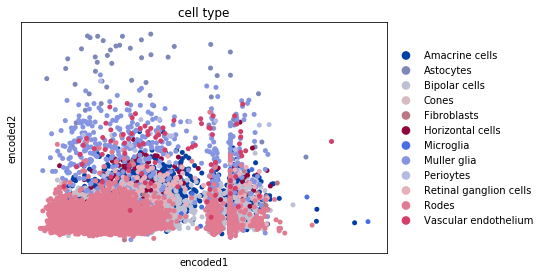

In [23]:
sc.pl.scatter(adata, basis='encoded', color='cell_type', size=100)

In [24]:
large_clusters = adata.obs['cell_type']

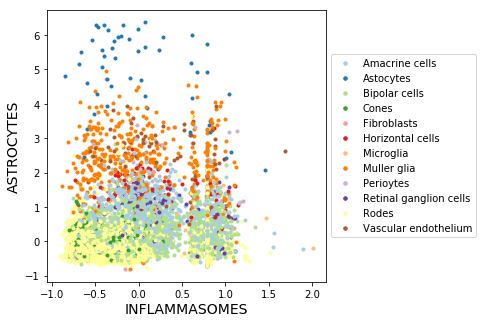

In [25]:
fg = plotFactors(terms=['INFLAMMASOMES', 'ASTROCYTES'], X=adata.obsm['X_encoded'], lab=large_clusters, isCont=False)

In [26]:
fa = h5py.File('FA.hdf5')

In [27]:
terms = fa['terms'][()]
to_plot = np.where(np.logical_or(terms == b'INFLAMMASOMES', terms == b'ASTROCYTES'))[0]

In [28]:
to_plot

array([135, 142])

In [29]:
(fa['Z'][:, 135].T>0.5).sum()

13

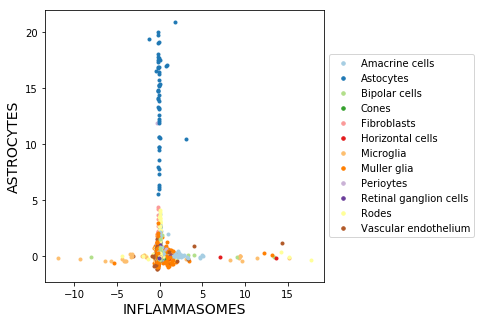

In [337]:
fg = sl.plotFactors(terms=['INFLAMMASOMES', 'ASTROCYTES'], X=fa['X'][:, to_plot], lab=large_clusters, isCont=False)

In [302]:
t_X = torch.from_numpy(adata.X)

autoencoder1 = MaskedAutoencoder(adata.n_vars, len(adata.uns['terms']), 10)

logits1 = autoencoder1.encoder[0].logits
logits2 = autoencoder1.encoder[2].logits

autoencoder1 = autoencoder1.eval()

_, t_decoded = autoencoder1(t_X)

loss_func(t_decoded, t_X, logits1, logits2)

In [31]:
torch.save(autoencoder, 'auto.pt')